# Descriptive Stats Tests 1

## Goal plots
- bar graph of pla activity cycle
    - `dur_day_total_{activity cycle}_min_pla`
    - `dur_day_spt_min_pla`
    - calculate any missing time as unidentified
    - in part 5 person summary, or could do day summary by day


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
test_df_p5_person = pd.read_csv('/Volumes/vosslabhpc/Projects/BOOST/ObservationalStudy/3-experiment/data/act-obs-test/derivatives/GGIR-3.2.6-test/sub-7016/accel/output_accel/results/part5_personsummary_MM_L40M100V400_T5A5.csv')
test_df_p5_day = pd.read_csv('/Volumes/vosslabhpc/Projects/BOOST/ObservationalStudy/3-experiment/data/act-obs-test/derivatives/GGIR-3.2.6-test/sub-7016/accel/output_accel/results/part5_daysummary_MM_L40M100V400_T5A5.csv')

In [4]:
act_cycles = ['IN', 'LIG', 'MOD', 'VIG']

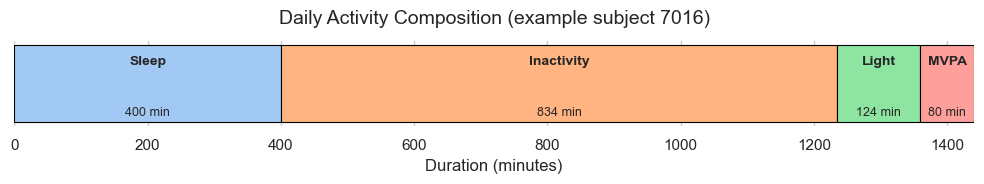

In [16]:
def plot_activity_cycle(df_person, act_cycles=['IN', 'LIG', 'MOD', 'VIG'], sleep_col='dur_spt_min_pla'):
    """
    Plots a horizontal stacked bar of daily activity composition:
    Sleep, Inactivity, Light activity, MVPA, and Unidentified time (if any).
    """
    # Collect durations
    durations = {cycle: df_person[f'dur_day_total_{cycle}_min_pla'].iloc[0] for cycle in act_cycles}
    mvpa = durations.pop('MOD') + durations.pop('VIG')
    durations = {
        'Sleep': df_person[sleep_col].iloc[0],
        'Inactivity': durations['IN'],
        'Light': durations['LIG'],
        'MVPA': mvpa
    }
    total_minutes = 24 * 60
    identified = sum(durations.values())
    unidentified = total_minutes - identified
    if unidentified > 0:
        durations['Unidentified'] = unidentified

    # Order of segments
    segments = ['Sleep', 'Inactivity', 'Light', 'MVPA']
    if 'Unidentified' in durations:
        segments.append('Unidentified')
    values = [durations[s] for s in segments]

    # Styling
    sns.set_theme(style='whitegrid', rc={'axes.facecolor': 'white'})
    fig, ax = plt.subplots(figsize=(10, 2))
    palette = sns.color_palette('pastel', n_colors=len(segments))

    left = 0
    for seg, val, color in zip(segments, values, palette):
        ax.barh(
            y=0,
            width=val,
            left=left,
            height=0.5,
            color=color,
            edgecolor='black',
            linewidth=0.8
        )
        ax.text(
            left + val / 2,
            0.1,
            seg,
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )
        ax.text(
            left + val / 2,
            -0.15,
            f"{int(val)} min",
            ha='center',
            va='top',
            fontsize=9
        )
        left += val

    ax.set_xlim(0, total_minutes)
    ax.set_yticks([])
    ax.set_xlabel('Duration (minutes)', fontsize=12)
    ax.set_title('Daily Activity Composition (example subject 7016)', fontsize=14, pad=12)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    plt.tight_layout()
    plt.show()
plot_activity_cycle(test_df_p5_person)

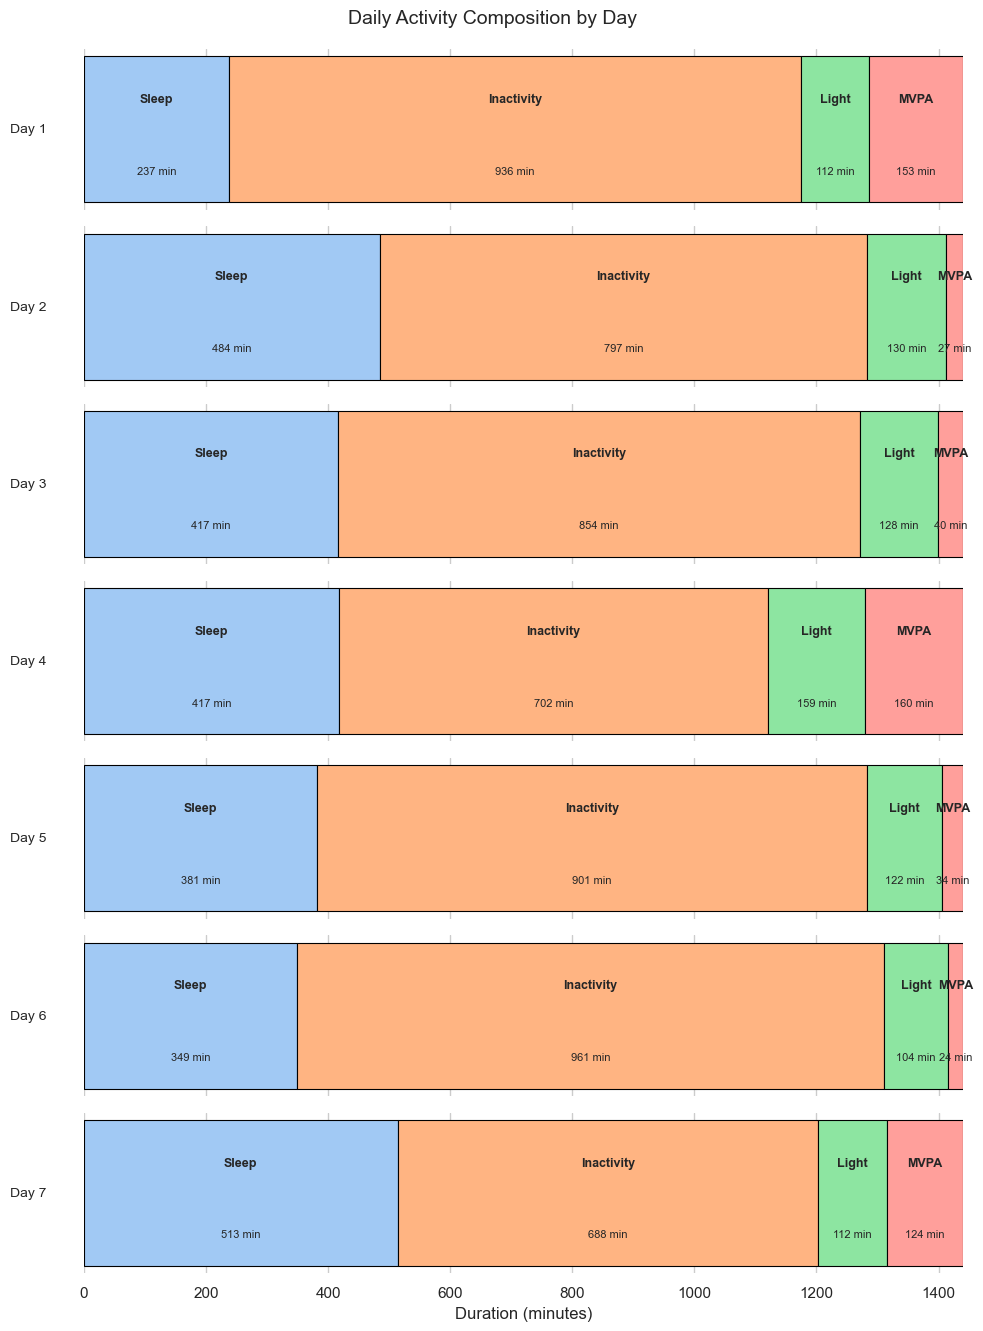

In [38]:
def plot_daily_activity_cycles(df_day,
                               act_cycles=['IN', 'LIG', 'MOD', 'VIG'],
                               sleep_col='dur_spt_min'):
    """
    Plots horizontal stacked bar charts for each day in df_day.
    Expects columns:
      dur_day_total_IN_min, dur_day_total_LIG_min,
      dur_day_total_MOD_min, dur_day_total_VIG_min, dur_spt_min
    """
    n_days = len(df_day)
    total_minutes = 24 * 60

    sns.set_theme(style='whitegrid', rc={'axes.facecolor': 'white'})
    fig, axes = plt.subplots(n_days, 1, figsize=(10, 2 * n_days), sharex=True)

    if n_days == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_day.iterrows()):
        # build durations
        durations = {
            'Sleep': row[sleep_col],
            'Inactivity': row['dur_day_total_IN_min'],
            'Light': row['dur_day_total_LIG_min'],
            'MVPA': row['dur_day_total_MOD_min'] + row['dur_day_total_VIG_min']
        }
        identified = sum(durations.values())
        unidentified = total_minutes - identified
        if unidentified > 1:
            durations['Unidentified'] = unidentified

        segments = list(durations.keys())
        values = [durations[s] for s in segments]
        palette = sns.color_palette('pastel', n_colors=len(segments))

        # inside the loop, replace placement logic with above‐bar placement for small segments:
        min_space = 20       # minutes threshold below which labels go above bar
        bar_height = 0.6
        left = 0
        for seg, val, color in zip(segments, values, palette):
            ax.barh(
                y=0,
                width=val,
                left=left,
                height=bar_height,
                color=color,
                edgecolor='black',
                linewidth=0.8
            )

            if val < min_space:
                # place labels above the bar
                seg_y = bar_height + 0.05
                val_y = bar_height + 0.20
                seg_va = 'bottom'
                val_va = 'bottom'
            else:
                # place labels inside the bar
                seg_y = 0.1
                val_y = -0.15
                seg_va = 'bottom'
                val_va = 'top'

            # segment name
            ax.text(
                left + val / 2,
                seg_y,
                seg,
                ha='center',
                va=seg_va,
                fontsize=9,
                fontweight='bold'
            )
            # duration value
            ax.text(
                left + val / 2,
                val_y,
                f"{int(val)} min",
                ha='center',
                va=val_va,
                fontsize=8
            )

            left += val

        ax.set_yticks([])
        ax.set_xlim(0, total_minutes)
        ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
        ax.set_ylabel(f"Day {int(row.name)+1}", rotation=0, labelpad=40, va='center', fontsize=10)

    axes[-1].set_xlabel('Duration (minutes)', fontsize=12)
    fig.suptitle('Daily Activity Composition by Day', fontsize=14, y=0.95)
    plt.tight_layout(h_pad=1.0, rect=[0, 0, 1, 0.96])
    plt.show()

plot_daily_activity_cycles(test_df_p5_day)